In [1]:
import ROOT

output = ROOT.TFile("sherpa_histograms.root", "RECREATE")
nbins = 25

ROOT.gStyle.SetOptStat(0)  # Disable stat box globally
tc = ROOT.TCanvas('angularities', 'angularities', 1200, 400)
tc.Divide(3, 1)
tc.cd(1)


In [2]:
# basedir="/global/homes/p/ploskon/D0jetAng"
# basedir="/Users/ploskon/data/Djet_ang/sherpa2x"
basedir="./"
files= {'AHADIC': "merged.root", "LUND": "merged_lund.root"}

def get_model_name_from_filename(fname):
    for fn in files:
        if files[fn] in fname:
            return fn
    return "unknonwn"

In [3]:
def get_number_of_jets(fname):
    tfile = ROOT.TFile(fname)
    tn = tfile.Get("tnR04")
    _htmp = ROOT.TH1F("_htmp", "_htmp", 25, 0, 25)
    tn.Draw("pt>>_htmp", "pt > 10 && pt < 20")
    _int = _htmp.Integral()
    tfile.Close()
    return _int

In [4]:
njets = {}
for fn in files:
    fname = f"{basedir}/{files[fn]}"
    njets[fn] = get_number_of_jets(fname)
print('njets:', njets)

njets: {'AHADIC': 27912.0, 'LUND': 16228.0}


In [5]:
import numpy as np
import array
def logbins(xmin, xmax, nbins):
	if xmin <= 0:
		xmin = 1e-2
	lspace = np.logspace(np.log10(xmin), np.log10(xmax), nbins+1)
	arr = array.array('f', lspace)
	return arr

def logbins_with_zero(xmin, xmax, nbins):
    if xmin <= 0:
        xmin = 1e-3
    lspace = np.logspace(np.log10(xmin), np.log10(xmax), nbins)
    arr = array.array('f', [0] + list(lspace))
    return arr

In [6]:
angularities = {"#lambda_{1}": "angk1a1", "#lambda_{1.5}": "angk1a1p5", "#lambda_{2}": "angk1a2"}
def make_histograms_from_file(fname, nbins, outputfile, histograms=None):
    if histograms is None:
        histograms = []
    for ang in angularities:
        tfile = ROOT.TFile(fname)
        tn = tfile.Get("tnR04")
        _varname = angularities[ang]
        _modelname = get_model_name_from_filename(fname)
        _hname = f"{_varname}_{_modelname}"
        _htitle = f"{ang} {_modelname}"
        outputfile.cd()
        # _htmp = ROOT.TH1F(_hname, _htitle, nbins, logbins_with_zero(0, 0.52, nbins))
        _htmp = ROOT.TH1F(_hname, _htitle, nbins, 0, 0.52)
        histograms.append(_htmp)
        tn.Draw(f"{_varname}>>{_hname}", "pt > 10 && pt < 20", "e")
        print(f'- filling {_hname} -> {histograms[-1].GetEntries()}')
        _njets = get_number_of_jets(fname)
        histograms[-1].Scale(1/_njets)
        print(f'- scaling {_hname} by 1/{_njets}')
        print(f'- integral in {_hname} after scaling: {histograms[-1].Integral()}')
    return histograms

In [7]:
histograms = []
for fn in files:
    fname = f"{basedir}/{files[fn]}"
    make_histograms_from_file(fname, nbins, output, histograms)
output.Write()

- filling angk1a1_AHADIC -> 27912.0
- scaling angk1a1_AHADIC by 1/27912.0
- integral in angk1a1_AHADIC after scaling: 0.9982803094899282
- filling angk1a1p5_AHADIC -> 27912.0
- scaling angk1a1p5_AHADIC by 1/27912.0
- integral in angk1a1p5_AHADIC after scaling: 0.9999641798021912
- filling angk1a2_AHADIC -> 27912.0
- scaling angk1a2_AHADIC by 1/27912.0
- integral in angk1a2_AHADIC after scaling: 1.0000000036379788
- filling angk1a1_LUND -> 16228.0
- scaling angk1a1_LUND by 1/16228.0
- integral in angk1a1_LUND after scaling: 0.9988908190280199
- filling angk1a1p5_LUND -> 16228.0
- scaling angk1a1p5_LUND by 1/16228.0
- integral in angk1a1p5_LUND after scaling: 0.9999999981373549
- filling angk1a2_LUND -> 16228.0
- scaling angk1a2_LUND by 1/16228.0
- integral in angk1a2_LUND after scaling: 1.0000000018626451


3691

In [8]:
colors = [ROOT.kRed, ROOT.kBlue]
lines = {'angk1a1': 1, 'angk1a1p5': 2, 'angk1a2': 9}
for h in histograms:
    if h is not None:
        h.GetXaxis().SetTitle("#lambda")
        h.GetYaxis().SetTitle("1/N dN/d#lambda")
        h.GetYaxis().SetTitleOffset(1.4)
        h.GetYaxis().SetTitleSize(0.05)
        h.GetXaxis().SetTitleSize(0.05)
        h.GetXaxis().SetTitleOffset(1.2)
        h.GetXaxis().SetLabelSize(0.04)
        h.GetYaxis().SetLabelSize(0.04)
        h.SetLineWidth(2)
        if "AHADIC" in h.GetName():
            h.SetLineColor(ROOT.kRed)
            h.SetMarkerColor(ROOT.kRed)
        else:
            h.SetLineColor(ROOT.kBlue)
            h.SetMarkerColor(ROOT.kBlue)
        h.SetMarkerStyle(0)
        h.SetMarkerSize(0)
        line_style = lines.get(h.GetName().split('_')[0], 1)
        h.SetLineStyle(line_style)
        #scale by the bin width
        for i in range(1, h.GetNbinsX()+1):
            bin_width = h.GetBinWidth(i)
            if bin_width > 0:
                h.SetBinContent(i, h.GetBinContent(i) / bin_width)
                h.SetBinError(i, h.GetBinError(i) / bin_width)
        # h.SetStats(0)
        
_ymax = max(h.GetMaximum() for h in histograms if h is not None)
for h in histograms:
    if h is not None:
        h.SetMaximum(_ymax * 1.2)
        h.SetMinimum(0)


In [9]:
data_file = "D0jet_angularity_w_pythia.root"
ang_data = [
    ["hmain_ang_R0.4_1_10-20_trunc_data", "D0-jet angularity DATA"],
    ["hmain_ang_R0.4_1.5_10-20_trunc_data", "D0-jet angularity DATA"],
    ["hmain_ang_R0.4_2_10-20_trunc_data", "D0-jet angularity DATA"]
]
ang_data_sys = [
    ["hmain_ang_totalsys_R0.4_1_10-20_trunc_data", "DATA - total sys"],
    ["hmain_ang_totalsys_R0.4_1.5_10-20_trunc_data", "DATA - total sys"],
    ["hmain_ang_totalsys_R0.4_2_10-20_trunc_data", "DATA - total sys"]
]

def draw_data(pad_number):
  fin = ROOT.TFile(data_file)
  h_data = fin.Get(ang_data[pad_number-1][0])
  h_data_sys = fin.Get(ang_data_sys[pad_number-1][0])
  if h_data is not None and h_data_sys is not None:
    h_data.SetTitle(ang_data[pad_number-1][1])
    h_data.SetMarkerStyle(24)
    h_data.SetMarkerSize(1.2)
    h_data.SetLineColor(ROOT.kMagenta)
    h_data.SetMarkerColor(ROOT.kMagenta)
    h_data_sys.SetFillColorAlpha(ROOT.kGray, 0.7)
    h_data_sys.SetLineColor(ROOT.kGray)
    h_data_sys.SetLineWidth(0)
    h_data_sys.SetMarkerColor(ROOT.kGray)
    h_data_sys.SetMarkerStyle(24)
    h_data_sys.SetMarkerSize(0)
    h_data_sys.SetTitle(ang_data_sys[pad_number-1][1])
    h_data_sys.DrawCopy("e2 same")
    h_data.DrawCopy("e same")
    fin.Close()


In [10]:
# Set margins for each pad
for i in range(3):
    pad_number = i + 1
    tc.cd(pad_number)
    ROOT.gPad.SetLeftMargin(0.15)
    ROOT.gPad.SetRightMargin(0.05)
    ROOT.gPad.SetTopMargin(0.08)
    ROOT.gPad.SetBottomMargin(0.15)

# Convert histograms to TGraphs for pure line drawing
graphs = []
for h in histograms:
    g = ROOT.TGraph(h)
    g.SetName(h.GetName() + "_graph")
    g.SetTitle(h.GetTitle())
    g.SetLineColor(h.GetLineColor())
    g.SetLineStyle(h.GetLineStyle())
    g.SetLineWidth(h.GetLineWidth())
    g.SetMaximum(h.GetMaximum())
    g.SetMinimum(h.GetMinimum())
    g.GetXaxis().SetTitle(h.GetXaxis().GetTitle())
    g.GetYaxis().SetTitle(h.GetYaxis().GetTitle())
    g.GetXaxis().SetTitleSize(h.GetXaxis().GetTitleSize())
    g.GetYaxis().SetTitleSize(h.GetYaxis().GetTitleSize())
    g.GetXaxis().SetTitleOffset(h.GetXaxis().GetTitleOffset())
    g.GetYaxis().SetTitleOffset(h.GetYaxis().GetTitleOffset())
    g.GetXaxis().SetLabelSize(h.GetXaxis().GetLabelSize())
    g.GetYaxis().SetLabelSize(h.GetYaxis().GetLabelSize())
    graphs.append(g)
    
# Draw graphs as lines
for i, g in enumerate(graphs):
    pad_number = i % 3 + 1
    tc.cd(pad_number)
    print(f'- drawing {g.GetName()}')
    if "LUND" not in g.GetName():
        _opt = ""
    else:
        _opt = "L"
    g.Draw(_opt + " same")
        
for i in range(3):
    pad_number = i + 1
    tc.cd(pad_number)
    draw_data(pad_number)
    tc.cd(pad_number).BuildLegend(0.2, 0.7, 0.9, 0.9, "Sherpa")
# tc.SetLogx()
tc.Draw()

- drawing angk1a1_AHADIC_graph
- drawing angk1a1p5_AHADIC_graph
- drawing angk1a2_AHADIC_graph
- drawing angk1a1_LUND_graph
- drawing angk1a1p5_LUND_graph
- drawing angk1a2_LUND_graph


In [11]:
output.Close()

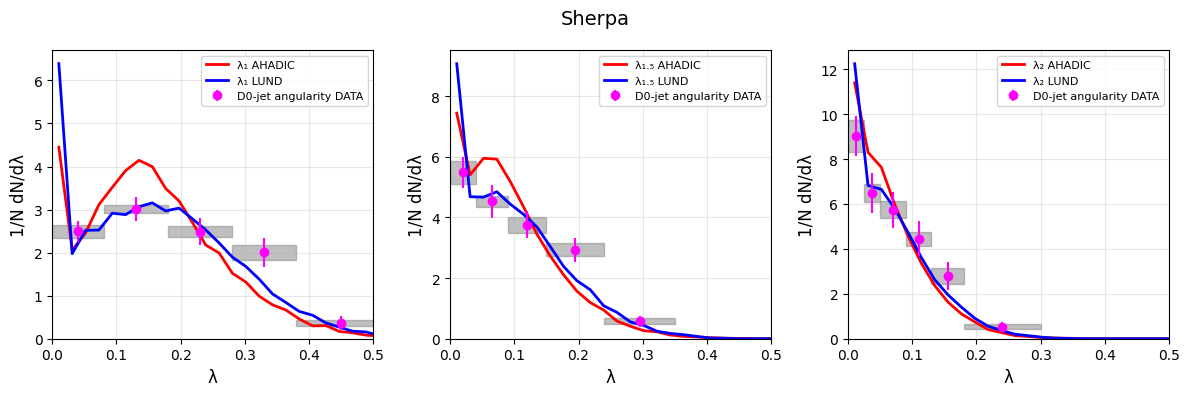

In [12]:
import matplotlib.pyplot as plt
import uproot
import numpy as np

# Read Sherpa histograms from the saved ROOT file using uproot
sherpa_root = uproot.open("sherpa_histograms.root")
hist_data = {}

# Get all histogram names and extract data
for key in sherpa_root.keys():
    name = key.split(';')[0]  # Remove cycle number
    h = sherpa_root[name]
    edges = h.axis().edges()
    x = (edges[:-1] + edges[1:]) / 2
    y = h.values()
    # Apply bin width normalization (same as done in cell 8)
    bin_widths = edges[1:] - edges[:-1]
    y = y / bin_widths
    hist_data[name] = {'x': x, 'y': y}

# Read data from ROOT file using uproot
data_root = uproot.open(data_file)
data_hists = {}
for i, (hname, label) in enumerate(ang_data):
    h = data_root[hname]
    x = (h.axis().edges()[:-1] + h.axis().edges()[1:]) / 2
    y = h.values()
    yerr = np.sqrt(h.variances())
    data_hists[i] = {'x': x, 'y': y, 'yerr': yerr, 'label': label}

data_sys_hists = {}
for i, (hname, label) in enumerate(ang_data_sys):
    h = data_root[hname]
    x = (h.axis().edges()[:-1] + h.axis().edges()[1:]) / 2
    y = h.values()
    yerr = np.sqrt(h.variances())
    data_sys_hists[i] = {'x': x, 'y': y, 'yerr': yerr, 'label': label}

# Create matplotlib figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Sherpa', fontsize=14)

angularity_names = ['λ₁', 'λ₁.₅', 'λ₂']
line_styles = {1: '-', 2: '--', 9: ':'}

for pad_idx in range(3):
    ax = axes[pad_idx]
    
    # Draw Sherpa histograms
    for h_name, data in hist_data.items():
        # Determine which pad this histogram belongs to based on angularity type
        if pad_idx == 0 and 'angk1a1_' not in h_name:
            continue
        elif pad_idx == 1 and 'angk1a1p5_' not in h_name:
            continue
        elif pad_idx == 2 and 'angk1a2_' not in h_name:
            continue
            
        # Skip if wrong angularity for this pad
        if pad_idx == 0 and ('angk1a1p5_' in h_name or 'angk1a2_' in h_name):
            continue
        elif pad_idx == 1 and ('angk1a1_' in h_name or 'angk1a2_' in h_name):
            continue
        elif pad_idx == 2 and ('angk1a1_' in h_name or 'angk1a1p5_' in h_name):
            continue
            
        # Determine color and label
        if 'AHADIC' in h_name:
            color = 'red'
            label = f'{angularity_names[pad_idx]} AHADIC'
        else:
            color = 'blue'
            label = f'{angularity_names[pad_idx]} LUND'
        
        # All use solid line style
        ls = '-'
            
        ax.plot(data['x'], data['y'], color=color, linestyle=ls, linewidth=2, label=label)
    
    # Draw data
    if pad_idx in data_sys_hists:
        ds = data_sys_hists[pad_idx]
        # Draw systematic uncertainties as rectangles
        for i in range(len(ds['x'])):
            # Get bin edges for rectangle width
            bin_edges = data_root[ang_data_sys[pad_idx][0]].axis().edges()
            bin_width = bin_edges[i+1] - bin_edges[i]
            rect_height = 2 * ds['yerr'][i]
            rect = plt.Rectangle((ds['x'][i] - bin_width/2, ds['y'][i] - ds['yerr'][i]), 
                                bin_width, rect_height, 
                                facecolor='gray', edgecolor='gray', alpha=0.5)
            ax.add_patch(rect)
    
    if pad_idx in data_hists:
        dd = data_hists[pad_idx]
        ax.errorbar(dd['x'], dd['y'], yerr=dd['yerr'], fmt='o', 
                   color='magenta', markersize=6, label='D0-jet angularity DATA')
    
    # Set labels and limits
    ax.set_xlabel('λ', fontsize=12)
    ax.set_ylabel('1/N dN/dλ', fontsize=12)
    ax.set_xlim(0, 0.5)
    ax.set_ylim(0, None)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
